# Model details
***Used base model***: bert-base-uncased
***Used dataset***: SQuAD
***Batch size***: 4
***Early stopping patience***: 2
***Early stopping monitor***: val loss
***Datasets***: Train: original 80k train samples, Val: remaining 7599 samples, Test: original 10570 samples
***Loss function***: Sparse categorical crossentropy
***Attempted train epochs***: 10
***Initial learning rate***: 2e-5
***End learning rate***: 0
***Additional info***: Makes use of stride mechanism, smart evaluation

In [1]:
from transformers import (
    AutoTokenizer,
    TFAutoModelForQuestionAnswering,
    DefaultDataCollator,
)
import tensorflow as tf
from question_answering.constants import constants
from question_answering.utils import core_qa_utils
from question_answering.utils.extractive_qa import model_management
from question_answering.paths import extractive_qa_paths
import ipynbname
from question_answering.keras_callbacks.time_measure_callback import TimeMeasureCallback
from tqdm.auto import tqdm
import evaluate
from collections import defaultdict
import numpy as np

# Data loading

In [2]:
raw_train_dataset, raw_test_dataset = core_qa_utils.load_datasets_from_json(
    dataset_path=extractive_qa_paths.squad_dataset_dir,
    filenames=["original_train.json", "original_test.json"],
)

In [3]:
train_dataset = raw_train_dataset.select(range(80000))
val_dataset = raw_train_dataset.select(range(80000, 87599))
test_dataset = raw_test_dataset

In [4]:
train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'answer_text', 'answer_start'],
     num_rows: 80000
 }),
 Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'answer_text', 'answer_start'],
     num_rows: 7599
 }),
 Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'answer_text', 'answer_start'],
     num_rows: 10570
 }))

# Data preprocessing

In [5]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [6]:
max_length = 384
stride = 128

In [7]:
def preprocess_training_dataset(dataset):
    questions = [q.strip() for q in dataset["question"]]
    contexts = [c.strip() for c in dataset["context"]]

    inputs = tokenizer(
        questions,
        contexts,
        max_length=max_length,
        padding="max_length",
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answer_starts = dataset["answer_start"]
    answer_texts = dataset["answer_text"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer_start = answer_starts[sample_idx][0]
        answer_text = answer_texts[sample_idx][0]
        start_char = answer_start
        end_char = start_char + len(answer_text)
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end TOKEN positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [8]:
def preprocess_test_samples(dataset):
    questions = [q.strip() for q in dataset["question"]]
    contexts = [c.strip() for c in dataset["context"]]

    inputs = tokenizer(
        questions,
        contexts,
        max_length=max_length,
        padding="max_length",
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(dataset["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [9]:
tokenized_train_dataset = train_dataset.map(
    preprocess_training_dataset,
    batched=True,
    remove_columns=train_dataset.column_names
)
tokenized_val_dataset = val_dataset.map(
    preprocess_training_dataset,
    batched=True,
    remove_columns=val_dataset.column_names
)

In [10]:
tokenized_test_dataset = test_dataset.map(
    preprocess_test_samples,
    batched=True,
    remove_columns=test_dataset.column_names
)

# Training preparation

In [11]:
# Model parameters
full_model_name = "-".join(ipynbname.name().split("_"))

# Checkpoints
checkpoint_filename_template = constants.checkpoint_filename_template
checkpoints_path = (
        extractive_qa_paths.training_checkpoints_dir
        / full_model_name
        / checkpoint_filename_template
)

# Saved models
saved_models_path = extractive_qa_paths.saved_models_dir / full_model_name

# Evaluation
model_evaluation_dir = extractive_qa_paths.model_evaluation_dir / full_model_name
figures_dir = model_evaluation_dir / constants.figures_dir_name

# Hyperparameters
batch_size = 4
train_epochs = 10
initial_learning_rate = 2e-5
end_learning_rate = 0

In [12]:
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_train_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)
tf_val_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_val_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)
tf_test_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_test_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=None,
    collator=data_collator,
    batch_size=batch_size,
)

In [13]:
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, verbose=1, save_weights_only=True
)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=2)
time_measure_cb = TimeMeasureCallback()

callbacks = [checkpoint_cb, early_stop_cb, time_measure_cb]

In [15]:
num_train_steps = len(tf_train_dataset) * train_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=end_learning_rate,
    decay_steps=num_train_steps,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [16]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


# Model training

In [17]:
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=train_epochs,
    callbacks=callbacks,
)

Epoch 1/10
20213/20213 [==============================] - ETA: 0s - loss: 2.4799 - end_logits_loss: 1.1951 - start_logits_loss: 1.2848 - end_logits_accuracy: 0.6688 - start_logits_accuracy: 0.6330
Epoch 1: saving model to D:\dev\projects\question-answering\extractive-qa\training-checkpoints\squad-bert-uncased-7\cp-01.ckpt
20213/20213 [==============================] - 3166s 156ms/step - loss: 2.4799 - end_logits_loss: 1.1951 - start_logits_loss: 1.2848 - end_logits_accuracy: 0.6688 - start_logits_accuracy: 0.6330 - val_loss: 2.0537 - val_end_logits_loss: 0.9640 - val_start_logits_loss: 1.0897 - val_end_logits_accuracy: 0.7293 - val_start_logits_accuracy: 0.6738
Epoch 2/10
20213/20213 [==============================] - ETA: 0s - loss: 1.4928 - end_logits_loss: 0.7082 - start_logits_loss: 0.7846 - end_logits_accuracy: 0.7869 - start_logits_accuracy: 0.7519
Epoch 2: saving model to D:\dev\projects\question-answering\extractive-qa\training-checkpoints\squad-bert-uncased-7\cp-02.ckpt
20213/

In [18]:
core_qa_utils.save_dict_as_json(
    dictionary=history.history,
    dir_path=model_evaluation_dir,
    filename="history.json"
)

history = core_qa_utils.read_json_as_dict(model_evaluation_dir / "history.json")

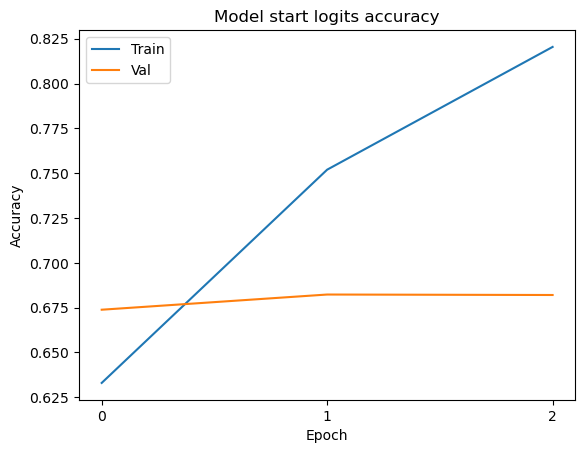

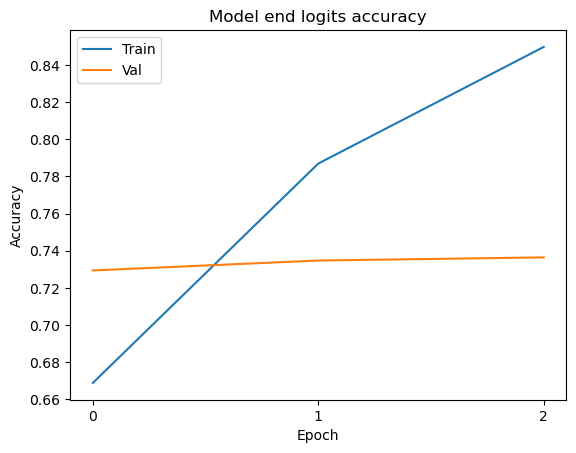

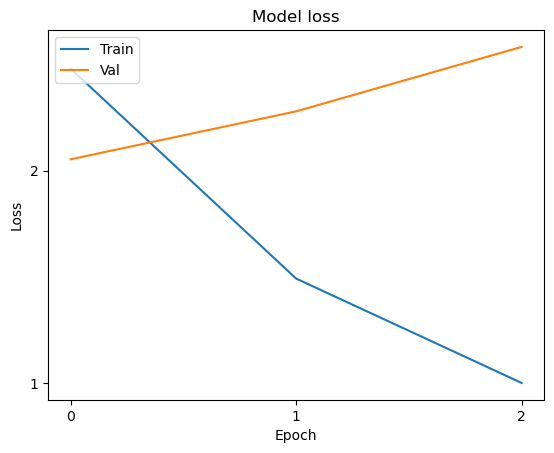

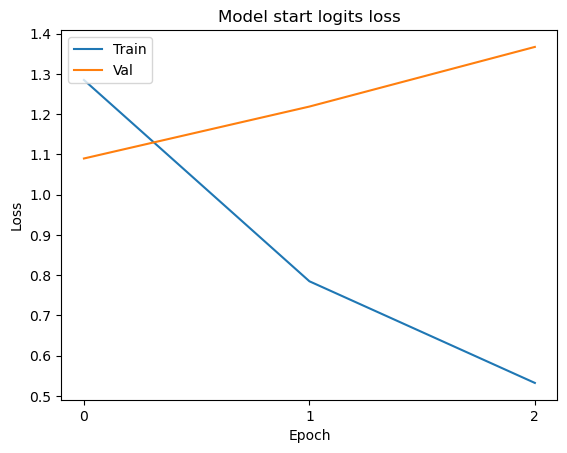

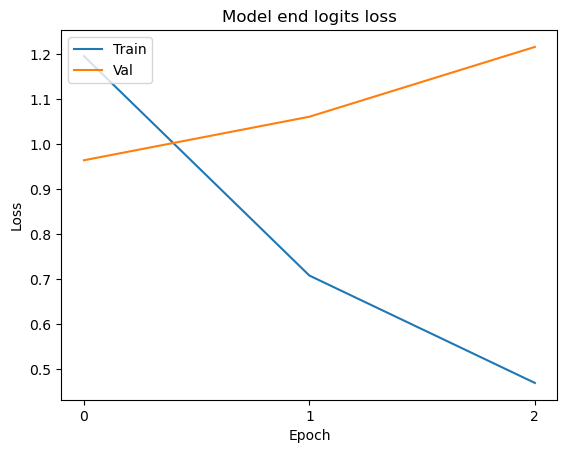

In [19]:
# Plot training figures
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["start_logits_accuracy", "val_start_logits_accuracy"],
    title="Model start logits accuracy",
    y_label="Accuracy",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_start_accuracy.png",
)

core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["end_logits_accuracy", "val_end_logits_accuracy"],
    title="Model end logits accuracy",
    y_label="Accuracy",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_end_accuracy.png",
)

core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["loss", "val_loss"],
    title="Model loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_loss.png",
)

core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["start_logits_loss", "val_start_logits_loss"],
    title="Model start logits loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_start_loss.png",
)

core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["end_logits_loss", "val_end_logits_loss"],
    title="Model end logits loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_end_loss.png",
)

# Saving model's best version

In [20]:
best_epoch = core_qa_utils.get_best_epoch(
    history=history,
    metric="val_loss",
    metric_evaluator="min"
)

In [21]:
# Get best version of the model
best_model = model_management.load_best_model_from_checkpoints(
    model=model,
    model_name=full_model_name,
    epoch=best_epoch,
    remove_checkpoints=False
)

In [22]:
# Save best model's weights
model_management.save_model(model=best_model, model_name=full_model_name)

# Getting predictions

In [23]:
loaded_model = model_management.load_model(
    model_checkpoint=model_checkpoint,
    model_name=full_model_name
)
loaded_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
output = loaded_model.predict(tf_test_dataset)

2696/2696 [==============================] - 111s 40ms/step


In [25]:
output_start_logits = output["start_logits"]
output_end_logits = output["end_logits"]

In [28]:
def convert_predictions_to_texts(start_logits, end_logits, features, examples, n_best=20, max_answer_length=30):
    example_to_features = defaultdict(list)

    for idx, feature in enumerate(features):
        example_id = feature["example_id"]
        example_to_features[example_id].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            best_start_indices = np.argsort(start_logit)[-1: -n_best - 1: -1].tolist()
            best_end_indices = np.argsort(end_logit)[-1: -n_best - 1: -1].tolist()
            for start_index in best_start_indices:
                for end_index in best_end_indices:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                            end_index < start_index
                            or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[
                                offsets[start_index][0]: offsets[end_index][1]
                                ],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(best_answer["text"])
        else:
            predicted_answers.append("")

    return predicted_answers

In [29]:
predicted_texts = convert_predictions_to_texts(
    start_logits=output_start_logits,
    end_logits=output_end_logits,
    features=tokenized_test_dataset,
    examples=test_dataset
)

  0%|          | 0/10570 [00:00<?, ?it/s]

In [30]:
model_predictions = test_dataset.add_column("prediction_text", predicted_texts)

In [31]:
def calculate_squad_exact_match(ids: list[str], answers: list[dict], predicted_texts: list[str]):
    metric = evaluate.load("squad")

    predictions = []
    references = []
    for i, example_id in enumerate(ids):
        predictions.append({"id": example_id, "prediction_text": predicted_texts[i]})
        references.append({"id": example_id, "answers": answers[i]})

    return metric.compute(predictions=predictions, references=references)


calculate_squad_exact_match(
    ids=model_predictions['id'],
    answers=model_predictions['answers'],
    predicted_texts=predicted_texts
)

Using the latest cached version of the module from C:\Users\Karol\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--squad\b4e2dbca455821c7367faa26712f378254b69040ebaab90b64bdeb465e4a304d (last modified on Sun Nov  5 01:44:59 2023) since it couldn't be found locally at evaluate-metric--squad, or remotely on the Hugging Face Hub.


{'exact_match': 78.89309366130558, 'f1': 86.91994022004037}

In [32]:
n_best = 20
max_answer_length = 30


def compute_metrics(start_logits, end_logits, features, examples):
    metric = evaluate.load("squad")

    example_to_features = defaultdict(list)
    for idx, feature in enumerate(features):
        example_id = feature["example_id"]
        example_to_features[example_id].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            best_start_indices = np.argsort(start_logit)[-1: -n_best - 1: -1].tolist()
            best_start_indices = np.argsort(end_logit)[-1: -n_best - 1: -1].tolist()
            for start_index in best_start_indices:
                for end_index in best_start_indices:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                            end_index < start_index
                            or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[
                                offsets[start_index][0]: offsets[end_index][1]
                                ],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [
        {"id": ex["id"], "answers": ex["answers"]} for ex in examples
    ]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)


compute_metrics(
    output_start_logits,
    output_end_logits,
    tokenized_test_dataset,
    test_dataset,
)

Using the latest cached version of the module from C:\Users\Karol\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--squad\b4e2dbca455821c7367faa26712f378254b69040ebaab90b64bdeb465e4a304d (last modified on Sun Nov  5 01:44:59 2023) since it couldn't be found locally at evaluate-metric--squad, or remotely on the Hugging Face Hub.


  0%|          | 0/10570 [00:00<?, ?it/s]

{'exact_match': 75.6480605487228, 'f1': 85.07176049105693}

In [34]:
time_measure_cb.total_training_time()

9364.988707100001